In [1]:
import numpy as np
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon import Block, HybridBlock
from mxnet.gluon.model_zoo import vision
from matplotlib import pyplot as plt
import os
from yolo_utils import *
import time
import pdb
from mxnet import autograd, image, gluon, nd
import json


def transform_center(xy):
    """Given x, y prediction after sigmoid(), convert to relative coordinates (0, 1) on image."""
    b, h, w, n, s = xy.shape
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    # print(offset_y[0].asnumpy()[:, :, 0, 0])
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    # print(offset_x[0].asnumpy()[:, :, 0, 0])
    x, y = xy.split(num_outputs=2, axis=-1)
    x = (x + offset_x) / w
    y = (y + offset_y) / h
    return x, y


# #### 长宽的转换
# 长宽是exp函数的输出，意义是相对于锚点长宽的比率，我们对预测值的exp()乘以相对锚点的长宽，除以图片格点的数量，得到的是目标长宽相对于图片的尺寸。

# In[ ]:


def transform_size(wh, anchors):
    """Given w, h prediction after exp() and anchor sizes, convert to relative width/height (0, 1) on image"""
    b, h, w, n, s = wh.shape
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h
    return w_out, h_out


# #### yolo2_forward作为一个方便使用的函数，会把卷积的通道分开，转换，最后转成我们需要的检测框
# 

# In[ ]:


def yolo2_forward(x, num_class, anchor_scales):
    """Transpose/reshape/organize convolution outputs."""
    stride = num_class + 5
    # transpose and reshape, 4th dim is the number of anchors
    x = x.transpose((0, 2, 3, 1))
    x = x.reshape((0, 0, 0, -1, stride))
    # now x is (batch, m, n, stride), stride = num_class + 1(object score) + 4(coordinates)
    # class probs
    cls_pred = x.slice_axis(begin=0, end=num_class, axis=-1)
    # object score
    score_pred = x.slice_axis(begin=num_class, end=num_class + 1, axis=-1)
    score = nd.sigmoid(score_pred)
    # center prediction, in range(0, 1) for each grid
    xy_pred = x.slice_axis(begin=num_class + 1, end=num_class + 3, axis=-1)
    xy = nd.sigmoid(xy_pred)
    # width/height prediction
    wh = x.slice_axis(begin=num_class + 3, end=num_class + 5, axis=-1)
    # convert x, y to positions relative to image
    x, y = transform_center(xy)
    # convert w, h to width/height relative to image
    w, h = transform_size(wh, anchor_scales)
    # cid is the argmax channel
    cid = nd.argmax(cls_pred, axis=-1, keepdims=True)
    # convert to corner format boxes
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1)
    top = nd.clip(y - half_h, 0, 1)
    right = nd.clip(x + half_w, 0, 1)
    bottom = nd.clip(y + half_h, 0, 1)
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4) # 为什么left和top有很多0？
    return output, cls_pred, score, nd.concat(*[xy, wh], dim=4)


# ### 定义一个函数来生成yolo2训练目标
# YOLO2寻找真实目标的方法比较特殊，是在每个格点内各自比较，而不是使用全局的预设。而且我们不需要对生成的训练目标进行反向传播，为了简洁描述比较的方法，我们可以在这里转成NumPy而且可以用for循环（切记转成NumPy会破坏自动求导的记录，只有当反向传播不需要的时候才能使用这个技巧），实际使用中，如果遇到速度问题，我们可以用mx.ndarray矩阵的写法来加速。
# 这里我们使用了一个技巧：sample_weight（个体权重）矩阵， 用于损失函数内部权重的调整，我们也可以通过权重矩阵来控制哪些个体需要被屏蔽，这一点在目标检测中尤其重要，因为往往大多数的背景区域不需要预测检测框。

# In[4]:


def corner2center(boxes, concat=True):
    """Convert left/top/right/bottom style boxes into x/y/w/h format"""
    left, top, right, bottom = boxes.split(axis=-1, num_outputs=4)
    x = (left + right) / 2
    y = (top + bottom) / 2
    width = right - left
    height = bottom - top
    if concat:
        last_dim = len(x.shape) - 1
        return nd.concat(*[x, y, width, height], dim=last_dim)
    return x, y, width, height

def center2corner(boxes, concat=True):
    """Convert x/y/w/h style boxes into left/top/right/bottom format"""
    x, y, w, h = boxes.split(axis=-1, num_outputs=4)
    w2 = w / 2
    h2 = h / 2
    left = x - w2
    top = y - h2
    right = x + w2
    bottom = y + h2
    if concat:
        last_dim = len(left.shape) - 1
        return nd.concat(*[left, top, right, bottom], dim=last_dim)
    return left, top, right, bottom


# In[5]:


def yolo2_target(scores, boxes, labels, anchors, ignore_label=-1, thresh=0.5):
    """Generate training targets given predictions and labels.
    网络预测的输出为(32,16,16,2,5)
    而label的形式为：labels即ground truth(32,1,5)，其中5包括一个class label:0，以及左上、右下两个corner相对于整张图的坐标
    模型回归的目标形式：

    注意：这里传入scores只是为了用其shape和context！


    """
    b, h, w, n, _ = scores.shape
    anchors = np.reshape(np.array(anchors), (-1, 2))
    #scores = nd.slice_axis(outputs, begin=1, end=2, axis=-1)
    #boxes = nd.slice_axis(outputs, begin=2, end=6, axis=-1)
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1)
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)  #注意：sample_weight的设置：只有和真实框的IOU最大的bbox sample_weight为1 ！！
    for b in range(output.shape[0]): #b为遍历batch_size个batch中的每一个
        # find the best match for each ground-truth
        label = labels[b].asnumpy()
        # 下一句仅仅是为了过滤掉错误的（小于零）的标签
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        # shuffle because multi gt could possibly match to one anchor, we keep the last match randomly
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)  #算出第几行第几列的cell对当前groundtruth box负责
            ind_y = int(gy * h)
            tx = gx * w - ind_x  # 得出groudtruth的中心坐标相对于要负责的grid cell左上角点的偏移，【【该偏移量即模型要回归的目标数值！！！】】
            ty = gy * h - ind_y
            gw = gw * w  #得出groudtruth box 在feature map上的绝对宽度和高度  如 gw=4.23  gh=6.53
            gh = gh * h
            # find the best match using width and height only, assuming centers are identical
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)  #计算每个(共两个) anchor box与groundtruth bbox的交集面积
            ovps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)  # 计算每个(共两个) anchor box与groundtruth bbox的交并比
            best_match = int(np.argmax(ovps))  #哪一个预先设定的bbox形状与groundtruth bbox的形状最匹配
            target_id[b, ind_y, ind_x, best_match, :] = l[0] #### 将best_match的bbox的类别设置为该groudtruth bbox的类别
            target_score[b, ind_y, ind_x, best_match, :] = 1.0  #将best_match的bbox的score赋为1，其他bbox的score都为零
            tw = np.log(gw / anchors[best_match, 0])  #【【？？？？？？？？？？？？？？？？】】
            th = np.log(gh / anchors[best_match, 1])
            target_box[b, ind_y, ind_x, best_match, :] = mx.nd.array([tx, ty, tw, th])   #tx, ty, tw, th 即网络输出的四个坐标讯息
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
            # print('ind_y', ind_y, 'ind_x', ind_x, 'best_match', best_match, 't', tx, ty, tw, th, 'ovp', ovps[best_match], 'gt', gx, gy, gw/w, gh/h, 'anchor', anchors[best_match, 0], anchors[best_match, 1])
    return target_id, target_score, target_box, sample_weight


# ### 我们用YOLO2Output作为yolo2的输出层，其实本质就是一个HybridBlock，内部包了一个卷积层作为最终的输出
# 

# In[6]:


class YOLO2Output(HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super(YOLO2Output, self).__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required"
        assert len(anchor_scales) > 0, "at least one anchor scale required"
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = nn.Conv2D(out_channels, 1, 1)

    def hybrid_forward(self, F, x, *args):
        return self.output(x)


In [2]:
def get_iterators(data_shape, batch_size, data_dir):
    class_names = ['hand', 'dummy']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        std=True,
        rand_gray = 1,
        brightness = 0.3,
        contrast = 0.3,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200
        )
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True,
        std=True)
    return train_iter, val_iter, class_names, num_class

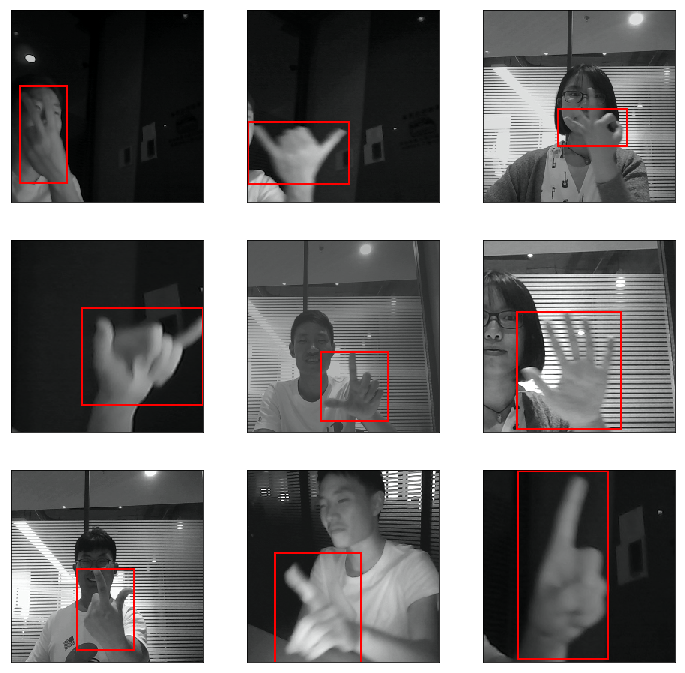

In [3]:
data_shape = 256
batch_size = 32
data_dir = '/home/users/chengyuan.yang/Further_Dataset_Process/rec_dataset/'
RGB_MEAN = nd.array([123, 117, 104])
RGB_STD = nd.array([58.395, 57.12, 57.375])
train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size, data_dir)
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

batch = train_data.next()
_, figs = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        img = img.transpose((1, 2, 0)) * RGB_STD + RGB_MEAN
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

## Evaluation functions

In [4]:
ctx = mx.gpu(2)
RGB_STD = RGB_STD.as_in_context(ctx)
RGB_MEAN = RGB_MEAN.as_in_context(ctx)
def plot_prediction(test_img, test_pred, n_epoch, n_iter):
    %matplotlib inline
    _, figs = plt.subplots(3, 3, figsize=(12,12))
    for i in range(3):
        for j in range(3):
            im, l = test_img[3*i+j], test_pred[3*i+j]
            im = im.transpose((1, 2, 0)) * RGB_STD + RGB_MEAN
            im = im.clip(0,255).asnumpy()/255
            fig = figs[i][j]
            fig.imshow(im)
            rect = box_to_rect(l * data_shape,'red',2)
            fig.add_patch(rect)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
    
    plt.savefig('training_eval/{0}_{1}_eval.jpg'.format(n_epoch,n_iter))
    #plt.show()
    plt.clf()
def evaluate(net, n_epoch, n_iter):
    test_batch  = test_data.next()
    test_img = test_batch.data[0].as_in_context(ctx)
    test_label = test_batch.label[0].as_in_context(ctx)
    test_out = predict(net, test_img)
    test_pred = test_out[:,0,-4:]
    test_lb = test_label.squeeze()[:,1:]
    loss = nd.mean(l1_loss(test_pred, test_lb))
    print('Epoch: {0}    Iteration: {1}    Evaluation loss: {2}'.format(n_epoch, n_iter, loss))
    plot_prediction(test_img, test_pred, n_epoch, n_iter)
    return loss
#evaluate(net, 1,2)

In [5]:
sce_loss = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False)
l1_loss = gluon.loss.L1Loss()

positive_weight = 20.0
negative_weight = 0.1
class_weight = 2.0
box_weight = 10.0

pretrained = vision.get_model('resnet18_v1', pretrained=True).features
net = nn.HybridSequential()
for i in range(len(pretrained) - 2):
    net.add(pretrained[i])
predictor = YOLO2Output(2, scales)
predictor.initialize()
net.add(predictor)
# anchor scales, try adjust it yourself
scales = [[4.0, 4.8],   #每一行表示一个预先选定的bbox形状，第一列为width，第二列为height。【【这里的数值不是在全图上的数值，而是根据网络输出feature map的大小(256/16=16)定的】】
          [4.8, 4.8],
          [5.6, 4.0],
          [4.8, 8.0],
          [6.4, 6.4]]#对数据集中的groundtruth box做聚类，聚类个数k为bbox的个数，k个聚类中心bbox的宽高维度为bbox的维度

# use 2 classes, 1 as dummy class, otherwise softmax won't work


ckpt_dir = 'models_brightness_jitter/'
if os.path.exists(ckpt_dir):
    try:
        params_list = os.listdir(ckpt_dir)
        latest_param = sorted(params_list, key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1]
        start_epoch = int(latest_param.split('.')[0].split('_')[-1])+1
        print('Loading saved weights: {}...'.format(latest_param))
        net.load_parameters(ckpt_dir + latest_param)
    except:
        start_epoch = 0
else:
    start_epoch = 0



# ### 这里我们还是需要GPU来加速训练

ctx = mx.gpu(2)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(),
                        'adam', {'learning_rate': 0.000001, 'wd': 5e-4})



#net.load_parameters('model_saved_5_anchors/anchor_num_3_199.params')
#net.load_parameters('/home/users/chengyuan.yang/Pycharm_Project/hands_detector/yolo_v2/models_brightness_jitter/anchor_num_3_46.params')

Loading saved weights: anchor_num_3_277.params...


In [ ]:
data_shape = 256
batch_size = 64
rgb_mean = nd.array([123, 117, 104])
rgb_std = nd.array([58.395, 57.12, 57.375])


data_dir = '/home/users/chengyuan.yang/Further_Dataset_Process/rec_dataset/'

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size, data_dir)

loss_history = []
for epoch in range(start_epoch, 500):
    loss_history = []
    # reset data iterators and metrics
    train_data.reset()
    test_data.reset()
    # cls_loss.reset()
    # obj_loss.reset()
    # box_loss.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        #f = lambda i: predict(x[i], net, 'prediction_{}'.format(i));plt.clf()
        #map(f, range(32))
        with autograd.record():
            x = net(x)
            output, cls_pred, score, xywh = yolo2_forward(x, 2, scales)
            # 返回：转换之后的所有属性(32,16,16,2,6)，原始的cls_pred，转换过的score，以及原始的x,y,w,h信息
            with autograd.pause():
                tid, tscore, tbox, sample_weight = yolo2_target(score, xywh, y, scales, thresh=0.5)
            # losses
            loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
            score_weight = nd.where(sample_weight > 0,
                                    nd.ones_like(sample_weight) * positive_weight,
                                    nd.ones_like(sample_weight) * negative_weight)
            loss2 = l1_loss(score, tscore, score_weight)
            loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
            loss = loss1 + loss2 + loss3
        loss.backward()
        trainer.step(batch_size)

        if i%50 == 0:
            try:
                epoch_loss = evaluate(net, epoch, i)
                loss_history.append(epoch_loss)
#                 cls_loss_record = nd.mean(loss1).asscalar()
#                 obj_loss_record = nd.mean(loss2).asscalar()
#                 box_loss_record = nd.mean(loss3).asscalar()
#                 loss_dict = {'Epoch': epoch, 'iter': i, 'cls_loss':float(cls_loss_record), 'obj_loss':float(obj_loss_record), 'box_loss':float(box_loss_record)}
#                 with open('loss_log.json', 'a') as f:
#                     f.write(json.dumps(loss_dict) + '\n')
#                 #loss_history.append(loss_dict)
#                 print('Epoch: {0}, iter: {1},  cls_loss: {2:.6g}  obj_loss: {3:.6g}  box_loss: {4:.6g}'.format(epoch, i, cls_loss_record, obj_loss_record, box_loss_record))
            except:
                print('BUG: ndarray to numpy error...')
    print('---- Epoch {0}    Average Loss: {1} ---- '.format(epoch, np.mean(map(lambda x : x.asnumpy(), loss_history))))
    net.save_parameters(ckpt_dir + 'anchor_num_3_{}.params'.format(epoch))



Epoch: 278    Iteration: 0    Evaluation loss: 
[0.01818825]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 50    Evaluation loss: 
[0.01310092]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 100    Evaluation loss: 
[0.01417582]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 150    Evaluation loss: 
[0.0155462]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 200    Evaluation loss: 
[0.01712858]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 250    Evaluation loss: 
[0.02044984]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 300    Evaluation loss: 
[0.01477661]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 350    Evaluation loss: 
[0.0135882]
<NDArray 1 @gpu(2)>
Epoch: 278    Iteration: 400    Evaluation loss: 
[0.01424576]
<NDArray 1 @gpu(2)>
---- Epoch 278    Average Loss: 0.0156889092177 ---- 
Epoch: 279    Iteration: 0    Evaluation loss: 
[0.01746553]
<NDArray 1 @gpu(2)>
Epoch: 279    Iteration: 50    Evaluation loss: 
[0.01337925]
<NDArray 1 @gpu(2)>
Epoch: 279    Iteration: 100    Evaluatio

In [25]:
l1 = []
a =nd.array([1])
b = 2*nd.array([1])
l1.append(a)
l1.append(b)

In [28]:
np.mean(map(lambda x : x.asnumpy(), l1))

1.5